#### **1. Import Libraries and Load Data**

In [4]:

# Core libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Preprocessing libraries
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# Statistcal libraries
from scipy import stats
from scipy.stats import zscore, skew

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [5]:
df_eda = pd.read_csv("eda_cleaned.csv")
df_eda

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849.0,0.0,128.0,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583.0,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000.0,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900.0,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106.0,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072.0,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583.0,0.0,187.0,360.0,1.0,Urban,Y


#### **2. EDA-Based Data Quality Assessment**

**Based on EDA findings, let's assess the specific issues identified**

In [6]:
# Create a copy for preprocessing
df_p = df_eda.copy()
df_p.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849.0,0.0,128.0,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583.0,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000.0,0.0,141.0,360.0,1.0,Urban,Y


In [7]:
df_p = df_p.drop(columns='Loan_ID', inplace=False)

In [8]:
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education',
                    'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area']

numeric_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']


In [9]:
df_p['Loan_Status'] = df_p['Loan_Status'].map({'Y': 1, 'N': 0})

In [10]:
# 1. Check for missing values (EDA showed no missing values)
print("\n1. Missing Values:")
missing_values = df_p.isnull().sum()
if missing_values.sum() > 0:
    print(missing_values[missing_values > 0])
else:
    print("No missing values found (as expected from EDA)")
    

# 2. Check for duplicates
print("\n2. Duplicate Rows:")
duplicates = df_p.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
    print(f"Percentage of duplicates: {(duplicates/len(df_p))*100:.2f}%")
    
# 3. Check skewness for variables indentified in EDA as right-skewed
print("\n3. Skewness Analysis (EDA identified right-skewed variables):")
skewed_vars = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]
for var in skewed_vars:
    if var in df_p.columns:
        skewness = skew(df_p[var])
        print(f"{var}: skewness = {skewness:.3f} ({'right-skewed' if skewness > 0.5 else 'approximately normal'})")


1. Missing Values:
No missing values found (as expected from EDA)

2. Duplicate Rows:
Number of duplicate rows: 1
Percentage of duplicates: 0.16%

3. Skewness Analysis (EDA identified right-skewed variables):
ApplicantIncome: skewness = 1.037 (right-skewed)
CoapplicantIncome: skewness = 1.010 (right-skewed)
LoanAmount: skewness = 0.682 (right-skewed)


In [11]:
correlations = df_p.corr(numeric_only=True)['Loan_Status'].sort_values(key=abs, ascending=False)

corr_df = correlations.reset_index()
corr_df.columns = ['Feature', 'Correlation_with_LoanStatus']
corr_df['AbsCorrelation'] = corr_df['Correlation_with_LoanStatus'].abs()
corr_df = corr_df.sort_values('AbsCorrelation', ascending=False)

print("\nRanked Correlations with Loan_Status:")
display(corr_df)



Ranked Correlations with Loan_Status:


,Feature,Correlation_with_LoanStatus,AbsCorrelation
0,Loan_Status,1.000000,1.000000
1,Credit_History,0.540556,0.540556
2,LoanAmount,-0.047262,0.047262
3,Loan_Amount_Term,-0.022549,0.022549
4,CoapplicantIncome,0.011983,0.011983
5,ApplicantIncome,-0.000442,0.000442


In [12]:
#  Copy main DataFrame

df_encoded = df_p.copy()

# Identify categorical columns
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education',
                    'Self_Employed', 'Property_Area', 'Loan_Amount_Term']

# Credit_History stays numeric since it's already 0/1 categorical

# Encode categorical columns

le = LabelEncoder()
for col in categorical_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

# Confirm all columns are now numeric
print("\nEncoded Data Types:\n", df_encoded.dtypes)

# Correlation analysis
print("\nCorrelation with Loan_Status (EDA Evidence):")

# Drop Loan_Status AFTER correlation extraction, not before
correlations = df_encoded.corr(numeric_only=True)['Loan_Status'].sort_values(key=abs, ascending=False)

# Separate high- and low-signal features
print("\nHigh-signal features (|correlation| > 0.2):")
high_signal = correlations[abs(correlations) > 0.2].drop('Loan_Status', errors='ignore')
for feature, corr in high_signal.items():
    print(f"{feature}: {corr:.3f}")

print("\nLow-signal features (|correlation| < 0.1):")
low_signal = correlations[abs(correlations) < 0.1]
for feature, corr in low_signal.items():
    print(f"{feature}: {corr:.3f}")


corr_df = (
    correlations.drop('Loan_Status', errors='ignore')
    .reset_index()
    .rename(columns={'index': 'Feature', 'Loan_Status': 'Correlation_with_LoanStatus'})
)
corr_df['AbsCorrelation'] = corr_df['Correlation_with_LoanStatus'].abs()
corr_df = corr_df.sort_values('AbsCorrelation', ascending=False)

print("\nRanked Correlations:")
display(corr_df)


Encoded Data Types:
 Gender                 int32
Married                int32
Dependents             int32
Education              int32
Self_Employed          int32
ApplicantIncome      float64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term       int32
Credit_History       float64
Property_Area          int32
Loan_Status            int64
dtype: object

Correlation with Loan_Status (EDA Evidence):

High-signal features (|correlation| > 0.2):
Credit_History: 0.541

Low-signal features (|correlation| < 0.1):
Married: 0.091
Education: -0.086
LoanAmount: -0.047
Property_Area: 0.032
Gender: 0.018
CoapplicantIncome: 0.012
Dependents: 0.010
Loan_Amount_Term: -0.004
Self_Employed: -0.004
ApplicantIncome: -0.000

Ranked Correlations:


,Feature,Correlation_with_LoanStatus,AbsCorrelation
0,Credit_History,0.540556,0.540556
1,Married,0.091478,0.091478
2,Education,-0.085884,0.085884
3,LoanAmount,-0.047262,0.047262
4,Property_Area,0.032112,0.032112
5,Gender,0.017987,0.017987
6,CoapplicantIncome,0.011983,0.011983
7,Dependents,0.010118,0.010118
8,Loan_Amount_Term,-0.004123,0.004123
9,Self_Employed,-0.003700,0.003700


#### **Feature Engineering**

Implement the specific feature engineering recommendations from the EDA.

In [13]:
# Combine incomes
df_encoded['TotalIncome'] = df_encoded['ApplicantIncome'] + df_encoded['CoapplicantIncome']

# Ratio of loan amount to total income
df_encoded['Loan_to_Income_Ratio'] = df_encoded['LoanAmount'] / df_encoded['TotalIncome']

# Income per term
df_encoded['Income_per_Term'] = df_encoded['TotalIncome'] / df_encoded['Loan_Amount_Term']


In [14]:
print("\nNew Feature Summary:")
print(df_encoded[['TotalIncome', 'Loan_to_Income_Ratio', 'Income_per_Term']].describe())


New Feature Summary:
        TotalIncome  Loan_to_Income_Ratio  Income_per_Term
count    614.000000            614.000000       614.000000
mean    6036.813795              0.024192              inf
std     2635.181350              0.008216              NaN
min     1442.000000              0.003785       240.333333
25%     4166.000000              0.019676       715.666667
50%     5416.500000              0.024417       942.916667
75%     7452.500000              0.027875      1411.171875
max    15914.375000              0.082712              inf


In [15]:
# Replace inf and NaN with median of valid values
df_encoded['Income_per_Term'].replace([np.inf, -np.inf], np.nan, inplace=True)
median_income_term = df_encoded['Income_per_Term'].median()
df_encoded['Income_per_Term'].fillna(median_income_term, inplace=True)


In [16]:
print(df_encoded['Income_per_Term'].describe())


count     614.000000
mean     1189.035213
std       841.597143
min       240.333333
25%       715.666667
50%       941.500000
75%      1393.265625
max      7010.625000
Name: Income_per_Term, dtype: float64


In [17]:
print("\nNew Feature Summary:")
print(df_encoded[['TotalIncome', 'Loan_to_Income_Ratio', 'Income_per_Term']].describe())


New Feature Summary:
        TotalIncome  Loan_to_Income_Ratio  Income_per_Term
count    614.000000            614.000000       614.000000
mean    6036.813795              0.024192      1189.035213
std     2635.181350              0.008216       841.597143
min     1442.000000              0.003785       240.333333
25%     4166.000000              0.019676       715.666667
50%     5416.500000              0.024417       941.500000
75%     7452.500000              0.027875      1393.265625
max    15914.375000              0.082712      7010.625000


In [18]:
corrs = df_encoded.corr(numeric_only=True)['Loan_Status'].sort_values(key=abs, ascending=False)
print(corrs.head(10))


Loan_Status             1.000000
Credit_History          0.540556
Loan_to_Income_Ratio   -0.112336
Married                 0.091478
Education              -0.085884
LoanAmount             -0.047262
Property_Area           0.032112
Gender                  0.017987
Income_per_Term         0.013236
CoapplicantIncome       0.011983
Name: Loan_Status, dtype: float64


In [19]:
print("LOG-TRANSFORMING SKEWED VARIABLES")

# Variables identified in EDA
skewed_vars = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

for var in skewed_vars:
    if var in df_encoded.columns:
        min_val = df_encoded[var].min()
        if min_val <= 0:
            df_encoded[f'{var}_log'] = np.log1p(df_encoded[var])  # log(1 + x)
            method = "log1p"
        else:
            df_encoded[f'{var}_log'] = np.log(df_encoded[var])
            method = "log"
        
        original_skew = skew(df_encoded[var])
        transformed_skew = skew(df_encoded[f'{var}_log'])
        print(f"✓ {var}: Applied {method} transformation")
        print(f"  Original skew: {original_skew:.3f} → Transformed skew: {transformed_skew:.3f}")

print(f"\nDataset shape after log transformation: {df_encoded.shape}")
print("New log-transformed columns:", [col for col in df_encoded.columns if '_log' in col])


LOG-TRANSFORMING SKEWED VARIABLES
✓ ApplicantIncome: Applied log transformation
  Original skew: 1.037 → Transformed skew: -0.594
✓ CoapplicantIncome: Applied log1p transformation
  Original skew: 1.010 → Transformed skew: -0.184
✓ LoanAmount: Applied log transformation
  Original skew: 0.682 → Transformed skew: -0.937

Dataset shape after log transformation: (614, 18)
New log-transformed columns: ['ApplicantIncome_log', 'CoapplicantIncome_log', 'LoanAmount_log']


### **Data Splitting (Stratified)**

Based on EDA findings about class imbalance, use stratified splitting.

In [20]:
# Our preprocessed dataset
df_encoded.head()

# Seperate features and target
X = df_encoded.drop('Loan_Status', axis=1)
y = df_encoded['Loan_Status']


In [21]:
print("=== STRATIFIED DATA SPLITTING ===")
print("EDA identified class imbalance - using stratified splitting to preserve class distribution")
print("Preprocessed dataset shape:", df_encoded.shape)

# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: 75% train, 25% validation (of the 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

# Show split info
print(f"\nData split results:")
print(f"Training set: {X_train.shape} ({(X_train.shape[0]/len(X))*100:.1f}%)")
print(f"Validation set: {X_val.shape} ({(X_val.shape[0]/len(X))*100:.1f}%)")
print(f"Test set: {X_test.shape} ({(X_test.shape[0]/len(X))*100:.1f}%)")

# Class distribution check
print(f"\nClass distribution verification:")
print("Training set Loan_Status distribution:")
print(y_train.value_counts(normalize=True).sort_index())
print("\nValidation set Loan_Status distribution:")
print(y_val.value_counts(normalize=True).sort_index())
print("\nTest set Loan_Status distribution:")
print(y_test.value_counts(normalize=True).sort_index())


=== STRATIFIED DATA SPLITTING ===
EDA identified class imbalance - using stratified splitting to preserve class distribution
Preprocessed dataset shape: (614, 18)

Data split results:
Training set: (368, 17) (59.9%)
Validation set: (123, 17) (20.0%)
Test set: (123, 17) (20.0%)

Class distribution verification:
Training set Loan_Status distribution:
Loan_Status
0    0.3125
1    0.6875
Name: proportion, dtype: float64

Validation set Loan_Status distribution:
Loan_Status
0    0.317073
1    0.682927
Name: proportion, dtype: float64

Test set Loan_Status distribution:
Loan_Status
0    0.308943
1    0.691057
Name: proportion, dtype: float64


#### **Feature Selection**

Based on EDA correlation analysis, select high-signal features and evaluate low-signal ones.

In [22]:
# Feature selection based on EDA correlation evidence
print("FEATURE SELECTION BASED ON EDA CORRELATION EVIDENCE")

# EDA-identified high-signal features (|correlation| > 0.2)
high_signal_features = ['Credit_History']  # from our correlation results
print(f"\nEDA-identified high-signal features: {high_signal_features}")

# EDA-identified moderate-signal features (0.1 < |corr| ≤ 0.2)
moderate_signal_features = ['Loan_to_Income_Ratio']  # slightly predictive
print(f"EDA-identified moderate-signal features: {moderate_signal_features}")

# EDA-identified low-signal features (|correlation| < 0.1)
low_signal_features = [
    'Married', 'Education', 'LoanAmount', 'Property_Area', 'Gender',
    'CoapplicantIncome', 'Dependents', 'Loan_Amount_Term', 'Self_Employed', 'ApplicantIncome'
]
print(f"EDA-identified low-signal features: {low_signal_features}")

# Check which features are available
available_high_signal = [f for f in high_signal_features if f in X.columns]
available_low_signal = [f for f in low_signal_features if f in X.columns]

print(f"\nAvailable high-signal features: {available_high_signal}")
print(f"Available low-signal features: {available_low_signal}")

# Create feature sets for evaluation
print("\nFEATURE SETS FOR EVALUATION")

# Set 1: Exclude low-signal features
features_exclude_low_signal = [col for col in X.columns if col not in low_signal_features]
print(f"Set 1 - Exclude low-signal features: {len(features_exclude_low_signal)} features")

# Set 2: High-signal + engineered + log-transformed features
high_signal_plus_engineered = available_high_signal + [
    col for col in X.columns 
    if any(keyword in col.lower() for keyword in ['ratio', 'total', 'log', 'income'])
]
print(f"Set 2 - High-signal + engineered: {len(high_signal_plus_engineered)} features")

# Set 3: All features (for comparison)
all_features = list(X.columns)
print(f"Set 3 - All features: {len(all_features)} features")

# Choose your best feature set for baseline model (Set 2 recommended)
selected_features = list(set(high_signal_plus_engineered))  # avoid duplicates
print(f"\n✓ Selected feature set: {len(selected_features)} features")
print("Selected features:", selected_features)


FEATURE SELECTION BASED ON EDA CORRELATION EVIDENCE

EDA-identified high-signal features: ['Credit_History']
EDA-identified moderate-signal features: ['Loan_to_Income_Ratio']
EDA-identified low-signal features: ['Married', 'Education', 'LoanAmount', 'Property_Area', 'Gender', 'CoapplicantIncome', 'Dependents', 'Loan_Amount_Term', 'Self_Employed', 'ApplicantIncome']

Available high-signal features: ['Credit_History']
Available low-signal features: ['Married', 'Education', 'LoanAmount', 'Property_Area', 'Gender', 'CoapplicantIncome', 'Dependents', 'Loan_Amount_Term', 'Self_Employed', 'ApplicantIncome']

FEATURE SETS FOR EVALUATION
Set 1 - Exclude low-signal features: 7 features
Set 2 - High-signal + engineered: 9 features
Set 3 - All features: 17 features

✓ Selected feature set: 9 features
Selected features: ['CoapplicantIncome', 'TotalIncome', 'CoapplicantIncome_log', 'ApplicantIncome_log', 'LoanAmount_log', 'Loan_to_Income_Ratio', 'Income_per_Term', 'ApplicantIncome', 'Credit_History'

In [23]:
print("FEATURE SCALING (STANDARD SCALER)")
print("EDA recommended StandardScaler for numeric features only (to avoid scaling categorical ones)")

# Identify numeric columns to scale
numeric_features = [col for col in X_train.columns if col != 'Credit_History']
print(f"Numeric features to scale: {numeric_features}")

# Fit scaler only on training numeric columns
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_val_scaled[numeric_features] = scaler.transform(X_val[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

# Verify scaling
print("Scaling applied successfully!\n")
print(f"Training set scaled - Mean: {X_train_scaled[numeric_features].mean().mean():.4f}, Std: {X_train_scaled[numeric_features].std().mean():.4f}")
print(f"Validation set scaled - Mean: {X_val_scaled[numeric_features].mean().mean():.4f}, Std: {X_val_scaled[numeric_features].std().mean():.4f}")
print(f"Test set scaled - Mean: {X_test_scaled[numeric_features].mean().mean():.4f}, Std: {X_test_scaled[numeric_features].std().mean():.4f}")

# Confirm it behaves as expected
print("\nScaling verification:")
print(f"Training mean ≈ 0: {abs(X_train_scaled[numeric_features].mean().mean()) < 0.01}")
print(f"Training std ≈ 1: {abs(X_train_scaled[numeric_features].std().mean() - 1) < 0.01}")


FEATURE SCALING (STANDARD SCALER)
EDA recommended StandardScaler for numeric features only (to avoid scaling categorical ones)
Numeric features to scale: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Property_Area', 'TotalIncome', 'Loan_to_Income_Ratio', 'Income_per_Term', 'ApplicantIncome_log', 'CoapplicantIncome_log', 'LoanAmount_log']
Scaling applied successfully!

Training set scaled - Mean: 0.0000, Std: 1.0014
Validation set scaled - Mean: -0.0604, Std: 1.0158
Test set scaled - Mean: -0.0330, Std: 1.0365

Scaling verification:
Training mean ≈ 0: True
Training std ≈ 1: True


BASELINE MODEL: LOGISTIC REGRESSION

Validation Accuracy: 0.6829
Validation F1-Score: 0.7665
Test Accuracy: 0.8211
Test F1-Score: 0.8690

Classification Report (Validation Set)
              precision    recall  f1-score   support

           0      0.500     0.513     0.506        39
           1      0.771     0.762     0.766        84

    accuracy                          0.683       123
   macro avg      0.636     0.637     0.636       123
weighted avg      0.685     0.683     0.684       123



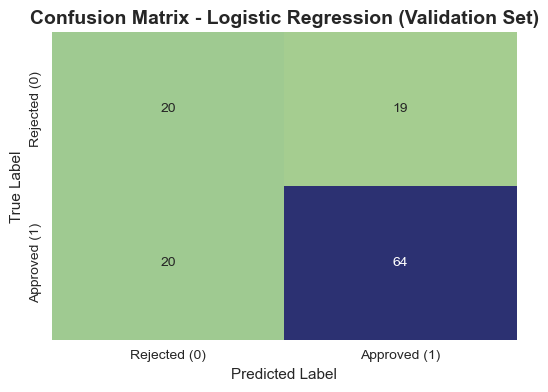

In [24]:
# Baseline Logistic Regression model
print("BASELINE MODEL: LOGISTIC REGRESSION")

# Create and train baseline model
baseline_model = LogisticRegression(
    random_state=42,
    solver='liblinear',
    class_weight='balanced',
    max_iter=1000
)

# Train the model
baseline_model.fit(X_train_scaled, y_train)

# Evaluate on validation and test sets
y_val_pred = baseline_model.predict(X_val_scaled)
y_test_pred = baseline_model.predict(X_test_scaled)

# Compute key metrics
val_acc_lr = accuracy_score(y_val, y_val_pred)
test_acc_lr = accuracy_score(y_test, y_test_pred)
val_f1_lr = f1_score(y_val, y_val_pred)
test_f1_lr = f1_score(y_test, y_test_pred)

print(f"\nValidation Accuracy: {val_acc_lr:.4f}")
print(f"Validation F1-Score: {val_f1_lr:.4f}")
print(f"Test Accuracy: {test_acc_lr:.4f}")
print(f"Test F1-Score: {test_f1_lr:.4f}")

# Classification report
print("\nClassification Report (Validation Set)")
print(classification_report(y_val, y_val_pred, digits=3))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)

# Visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='crest', cbar=False)
plt.title('Confusion Matrix - Logistic Regression (Validation Set)', fontsize=14, weight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=[0.5, 1.5], labels=['Rejected (0)', 'Approved (1)'])
plt.yticks(ticks=[0.5, 1.5], labels=['Rejected (0)', 'Approved (1)'])
plt.show()


DECISION TREE CLASSIFIER

Validation Accuracy: 0.7154
Validation F1-Score: 0.8087
Test Accuracy: 0.8049
Test F1-Score: 0.8652

Classification Report (Validation Set)
              precision    recall  f1-score   support

           0      0.583     0.359     0.444        39
           1      0.747     0.881     0.809        84

    accuracy                          0.715       123
   macro avg      0.665     0.620     0.627       123
weighted avg      0.695     0.715     0.693       123



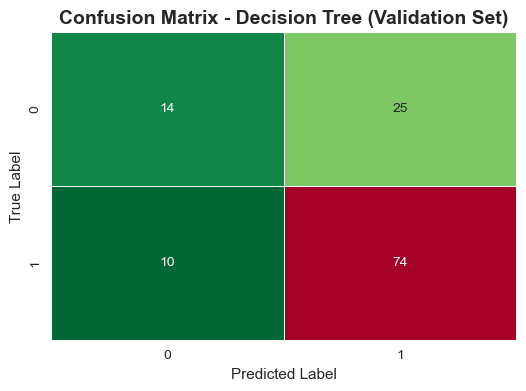

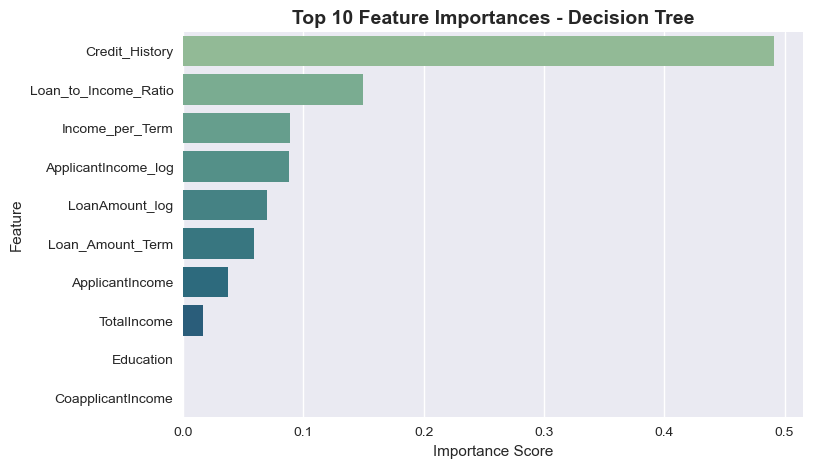


Feature Importance (All Features)
                  Feature    Importance
9          Credit_History  4.908348e-01
12   Loan_to_Income_Ratio  1.497806e-01
13        Income_per_Term  8.869126e-02
14    ApplicantIncome_log  8.813325e-02
16         LoanAmount_log  6.979607e-02
8        Loan_Amount_Term  5.871854e-02
5         ApplicantIncome  3.709960e-02
11            TotalIncome  1.694587e-02
3               Education  2.282728e-16
6       CoapplicantIncome  0.000000e+00
7              LoanAmount  0.000000e+00
1                 Married  0.000000e+00
10          Property_Area  0.000000e+00
4           Self_Employed  0.000000e+00
2              Dependents  0.000000e+00
15  CoapplicantIncome_log  0.000000e+00
0                  Gender  0.000000e+00


In [25]:
# Decision Tree Classifier
print("DECISION TREE CLASSIFIER")

# Initialize the Decision Tree
dt_model = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced',
    max_depth=5   # Limit depth to prevent overfitting
)

# Train the model
dt_model.fit(X_train_scaled, y_train)

# Make predictions
y_val_pred = dt_model.predict(X_val_scaled)
y_test_pred = dt_model.predict(X_test_scaled)

# Evaluate performance
val_acc_dt = accuracy_score(y_val, y_val_pred)
test_acc_dt = accuracy_score(y_test, y_test_pred)
val_f1_dt = f1_score(y_val, y_val_pred)
test_f1_dt = f1_score(y_test, y_test_pred)

print(f"\nValidation Accuracy: {val_acc_dt:.4f}")
print(f"Validation F1-Score: {val_f1_dt:.4f}")
print(f"Test Accuracy: {test_acc_dt:.4f}")
print(f"Test F1-Score: {test_f1_dt:.4f}")

print("\nClassification Report (Validation Set)")
print(classification_report(y_val, y_val_pred, digits=3))

# Confusion Matrix Visualization
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn_r', cbar=False, linewidths=0.5)
plt.title('Confusion Matrix - Decision Tree (Validation Set)', fontsize=14, weight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Feature importance visualization
feature_importances = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': dt_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=feature_importances.head(10), x='Importance', y='Feature', palette='crest')
plt.title('Top 10 Feature Importances - Decision Tree', fontsize=14, weight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# Display all importances sorted
print("\nFeature Importance (All Features)")
print(feature_importances)


RANDOM FOREST CLASSIFIER

Validation Accuracy: 0.7642
Validation F1-Score: 0.8449
Test Accuracy: 0.8455
Test F1-Score: 0.8914

Classification Report (Validation Set)
              precision    recall  f1-score   support

           0      0.750     0.385     0.508        39
           1      0.767     0.940     0.845        84

    accuracy                          0.764       123
   macro avg      0.758     0.663     0.677       123
weighted avg      0.762     0.764     0.738       123



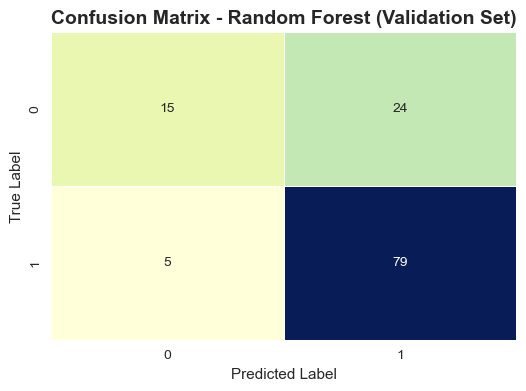

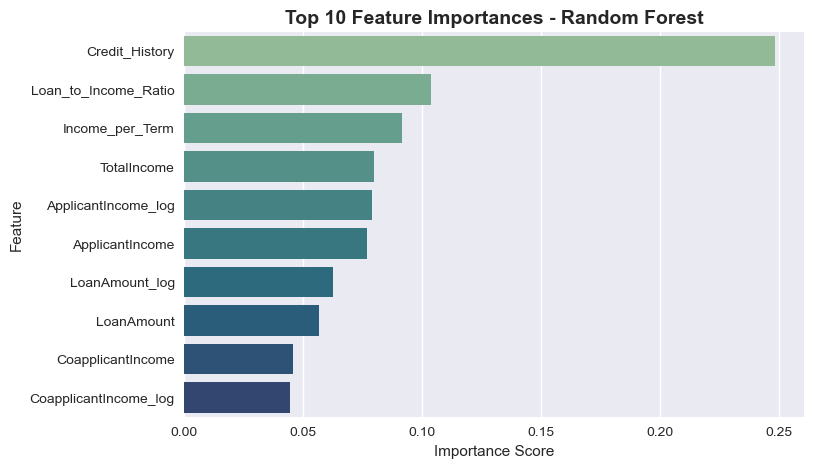


Feature Importance (All Features)
                  Feature  Importance
9          Credit_History    0.248447
12   Loan_to_Income_Ratio    0.103744
13        Income_per_Term    0.091645
11            TotalIncome    0.079694
14    ApplicantIncome_log    0.079104
5         ApplicantIncome    0.076792
16         LoanAmount_log    0.062422
7              LoanAmount    0.056608
6       CoapplicantIncome    0.045667
15  CoapplicantIncome_log    0.044592
10          Property_Area    0.030833
2              Dependents    0.025958
3               Education    0.015709
8        Loan_Amount_Term    0.014245
4           Self_Employed    0.009952
1                 Married    0.009664
0                  Gender    0.004925


In [26]:
# Random Forest Classifier
print("RANDOM FOREST CLASSIFIER")

# Create Random Forest model
rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=200,         # number of trees
    max_depth=8,             # limit tree depth to prevent overfitting
    class_weight='balanced',  # handle class imbalance
    n_jobs=-1                 # use all CPU cores for faster training
)

# Train the model
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_val_pred = rf_model.predict(X_val_scaled)
y_test_pred = rf_model.predict(X_test_scaled)

# Evaluate performance
val_acc_rf = accuracy_score(y_val, y_val_pred)
test_acc_rf = accuracy_score(y_test, y_test_pred)
val_f1_rf = f1_score(y_val, y_val_pred)
test_f1_rf = f1_score(y_test, y_test_pred)

print(f"\nValidation Accuracy: {val_acc_rf:.4f}")
print(f"Validation F1-Score: {val_f1_rf:.4f}")
print(f"Test Accuracy: {test_acc_rf:.4f}")
print(f"Test F1-Score: {test_f1_rf:.4f}")

print("\nClassification Report (Validation Set)")
print(classification_report(y_val, y_val_pred, digits=3))

# Confusion Matrix Visualization
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar=False, linewidths=0.5)
plt.title('Confusion Matrix - Random Forest (Validation Set)', fontsize=14, weight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Feature importance visualization
feature_importances = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=feature_importances.head(10), x='Importance', y='Feature', palette='crest')
plt.title('Top 10 Feature Importances - Random Forest', fontsize=14, weight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# Display all importances sorted
print("\nFeature Importance (All Features)")
print(feature_importances)


### **Confusion Matrix Breakdown**

| True Label ↓ / Predicted Label → | **0 (Rejected)** | **1 (Approved)** |
| -------------------------------- | ---------------- | ---------------- |
| **0 (Actual Rejected)**          | 15               | 24               |
| **1 (Actual Approved)**          | 5                | 79               |



**Below is what each cell means:**

- Top-left (15) -> **True Negatives (TN)**
--> 15 applications were actually rejected and the model also predicted them as rejected.

- Top-right (24) -> **False Positives (FP)**
--> 24 applications were actually rejected, but the model wrongly predicted them as approved.

- Bottom-left (5) -> **False Negatives (FN)**
--> 5 applications were actually approved, but the model predicted them as rejected.

- Bottom-right (79) -> **True Positives (TP)**
--> 79 applications were actually approved and the model predicted them as approved.


### **Model Interpretation**

| Metric                  | Meaning                                          | Formula           | Calculation                | Comment                                      |
| ----------------------- | ------------------------------------------------ | ----------------- | -------------------------- | -------------------------------------------- |
| **Accuracy**            | Overall correctness                              | (TP + TN) / Total | (79 + 15) / 123 ≈ **0.76** | Good overall accuracy                        |
| **Precision (class 1)** | How many predicted approvals were correct        | TP / (TP + FP)    | 79 / (79 + 24) ≈ **0.77**  | Slightly conservative — some false approvals |
| **Recall (class 1)**    | How many real approvals were correctly predicted | TP / (TP + FN)    | 79 / (79 + 5) ≈ **0.94**   | Excellent recall (few approved cases missed) |
| **F1-score (class 1)**  | Harmonic mean of precision and recall            | 2 × (P×R)/(P+R)   | ≈ **0.84–0.85**            | Very solid performance                       |


### **Insights**

**Strengths:**

- The model correctly identifies most approved loan applicants (high recall for class 1).

- Very few false rejections (FN = 5) -> that’s good for customer satisfaction.

**Weaknesses:**

- It tends to over-approve (FP = 24), meaning it sometimes predicts “Approved” when it shouldn’t.

- In banking, this can be risky, as it means approving customers who don’t qualify.


### **Business Interpretation**


| Case        | Meaning                            | Count | Business Impact             |
| ----------- | ---------------------------------- | ----- | --------------------------- |
| **TP (79)** | Correctly approved good applicants | 79    |  Desirable                 |
| **TN (15)** | Correctly rejected bad applicants  | 15    |  Safe decision             |
| **FP (24)** | Approved bad applicants            | 24    |  Financial risk           |
| **FN (5)**  | Rejected good applicants           | 5     |  Customer dissatisfaction |


XGBOOST CLASSIFIER

Validation Accuracy: 0.7073
Validation F1-Score: 0.7978
Test Accuracy: 0.7967
Test F1-Score: 0.8503

Classification Report (Validation Set)
              precision    recall  f1-score   support

           0      0.552     0.410     0.471        39
           1      0.755     0.845     0.798        84

    accuracy                          0.707       123
   macro avg      0.654     0.628     0.634       123
weighted avg      0.691     0.707     0.694       123



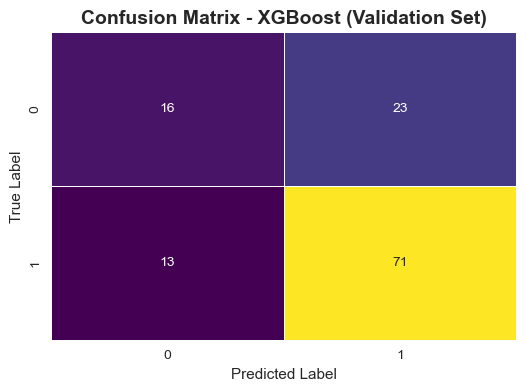

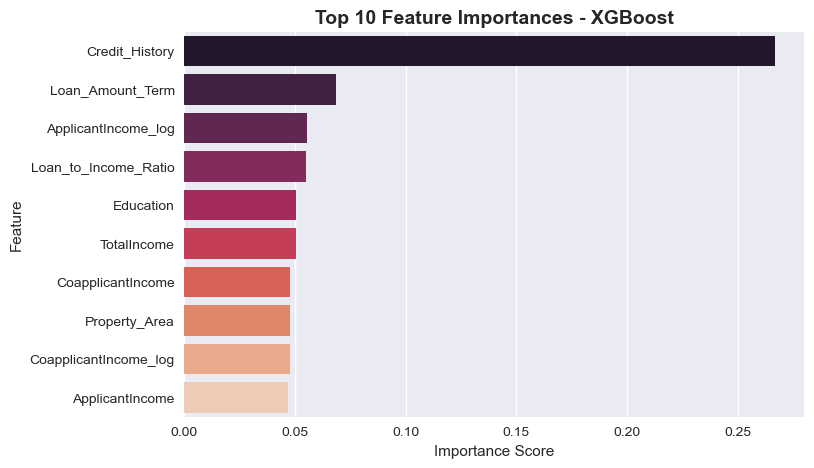


Feature Importance (All Features)
                  Feature  Importance
9          Credit_History    0.266811
8        Loan_Amount_Term    0.068314
14    ApplicantIncome_log    0.055441
12   Loan_to_Income_Ratio    0.055037
3               Education    0.050639
11            TotalIncome    0.050567
6       CoapplicantIncome    0.047764
10          Property_Area    0.047728
15  CoapplicantIncome_log    0.047656
5         ApplicantIncome    0.046684
13        Income_per_Term    0.043754
2              Dependents    0.043480
4           Self_Employed    0.042878
7              LoanAmount    0.038224
1                 Married    0.036273
0                  Gender    0.031387
16         LoanAmount_log    0.027363


In [29]:
# Xgboost Classifier
print("XGBOOST CLASSIFIER")

# Create Xgboost classifier model
xgb_model = XGBClassifier(
    random_state=42,
    n_estimators=300,           # number of boosting rounds
    learning_rate=0.05,         # smaller LR -> more stable training
    max_depth=4,                # controls model complexity
    subsample=0.8,              # fraction of rows used per tree
    colsample_bytree=0.8,       # fraction of features used per tree
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),  # handle class imbalance
    use_label_encoder=False,
    eval_metric='logloss'
)


# xgb_model = XGBClassifier(
#     random_state=42,
#     n_estimators=500,
#     learning_rate=0.1,
#     max_depth=5,
#     min_child_weight=1,
#     subsample=0.9,
#     colsample_bytree=0.9,
#     gamma=0.2,
#     reg_lambda=1,
#     reg_alpha=0.1,
#     scale_pos_weight=1,  # try without balancing first
#     eval_metric='logloss'
# )


# Train the model
xgb_model.fit(X_train_scaled, y_train)

# Make predictions
y_val_pred = xgb_model.predict(X_val_scaled)
y_test_pred = xgb_model.predict(X_test_scaled)

# Evaluate performance
val_acc_xgb = accuracy_score(y_val, y_val_pred)
test_acc_xgb = accuracy_score(y_test, y_test_pred)
val_f1_xgb = f1_score(y_val, y_val_pred)
test_f1_xgb = f1_score(y_test, y_test_pred)

print(f"\nValidation Accuracy: {val_acc_xgb:.4f}")
print(f"Validation F1-Score: {val_f1_xgb:.4f}")
print(f"Test Accuracy: {test_acc_xgb:.4f}")
print(f"Test F1-Score: {test_f1_xgb:.4f}")

print("\nClassification Report (Validation Set)")
print(classification_report(y_val, y_val_pred, digits=3))

# Confusion Matrix Visualization
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=False, linewidths=0.5)
plt.title('Confusion Matrix - XGBoost (Validation Set)', fontsize=14, weight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Feature importance visualization
feature_importances = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=feature_importances.head(10), x='Importance', y='Feature', palette='rocket')
plt.title('Top 10 Feature Importances - XGBoost', fontsize=14, weight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# Display all importances sorted
print("\nFeature Importance (All Features)")
print(feature_importances)



MODEL COMPARISON (VALIDATION + TEST SETS)
              Model  Validation Accuracy  Validation F1-Score  Test Accuracy  Test F1-Score
      Random Forest             0.764228             0.844920       0.845528       0.891429
      Decision Tree             0.715447             0.808743       0.804878       0.865169
            XGBoost             0.707317             0.797753       0.788618       0.852273
Logistic Regression             0.682927             0.766467       0.821138       0.869048


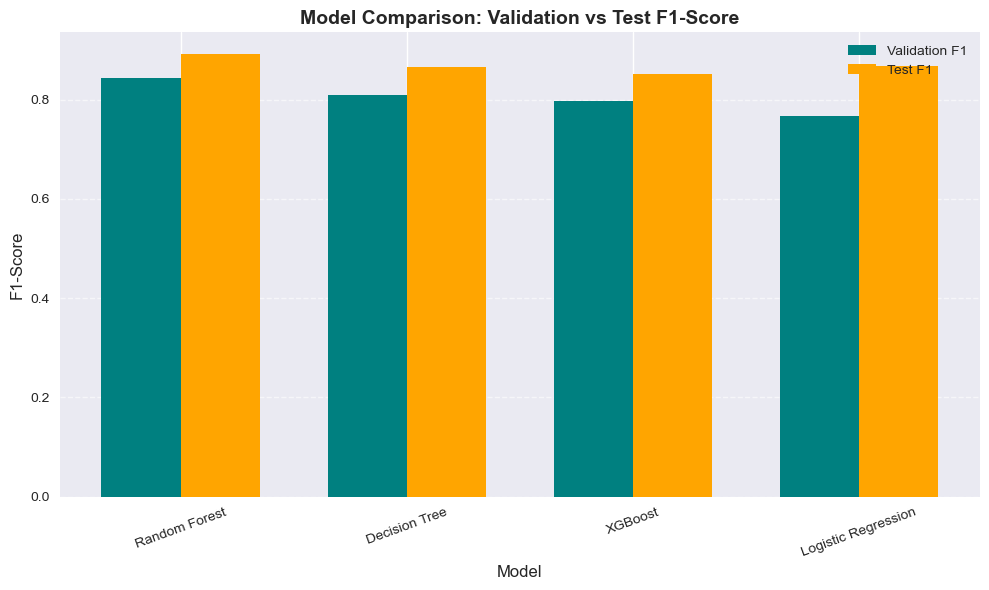

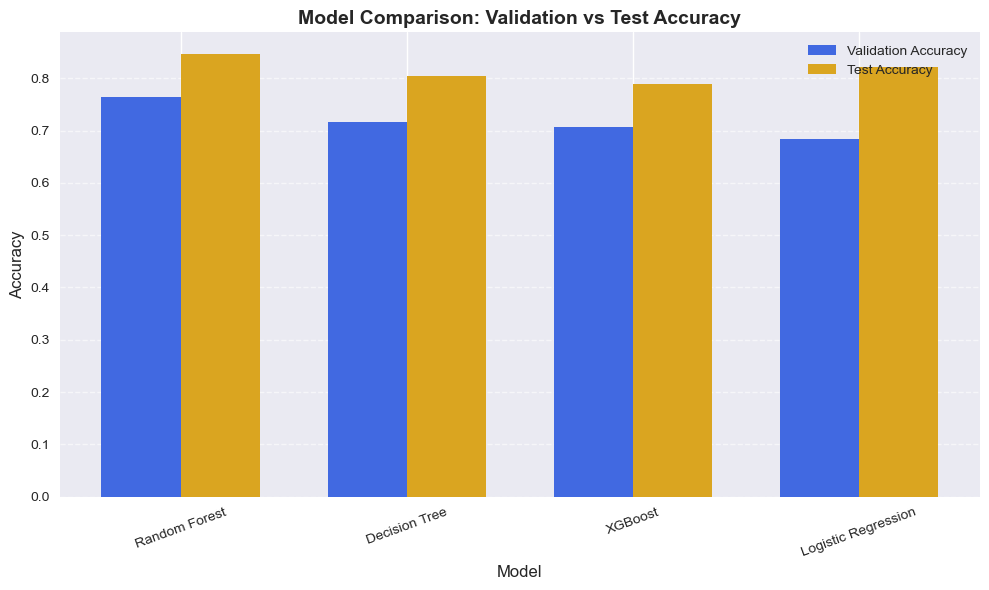

In [28]:
# Model comparison
model_results = pd.DataFrame({
    'Model': [
        'Logistic Regression',
        'Decision Tree',
        'Random Forest',
        'XGBoost'
    ],
    'Validation Accuracy': [
        val_acc_lr,
        val_acc_dt,
        val_acc_rf,
        val_acc_xgb
    ],
    'Validation F1-Score': [
        val_f1_lr,
        val_f1_dt,
        val_f1_rf,
        val_f1_xgb
    ],
    'Test Accuracy': [
        test_acc_lr,
        test_acc_dt,
        test_acc_rf,
        test_acc_xgb
    ],
    'Test F1-Score': [
        test_f1_lr,
        test_f1_dt,
        test_f1_rf,
        test_f1_xgb
    ]
})

# Sort models by Validation F1-Score (descending)
model_results = model_results.sort_values(by='Validation F1-Score', ascending=False)

# Display the comparison table
print("\nMODEL COMPARISON (VALIDATION + TEST SETS)")
print(model_results.to_string(index=False))

# Visualization: Validation vs Test F1-Score
plt.figure(figsize=(10,6))
bar_width = 0.35
models = model_results['Model']
x = range(len(models))

plt.bar(x, model_results['Validation F1-Score'], width=bar_width, label='Validation F1', color='teal')
plt.bar([i + bar_width for i in x], model_results['Test F1-Score'], width=bar_width, label='Test F1', color='orange')

plt.xlabel('Model', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.title('Model Comparison: Validation vs Test F1-Score', fontsize=14, weight='bold')
plt.xticks([i + bar_width / 2 for i in x], models, rotation=20)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Accuracy comparison
plt.figure(figsize=(10,6))
plt.bar(x, model_results['Validation Accuracy'], width=bar_width, label='Validation Accuracy', color='royalblue')
plt.bar([i + bar_width for i in x], model_results['Test Accuracy'], width=bar_width, label='Test Accuracy', color='goldenrod')

plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Comparison: Validation vs Test Accuracy', fontsize=14, weight='bold')
plt.xticks([i + bar_width / 2 for i in x], models, rotation=20)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
